In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [2]:
#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
from sklearn.preprocessing import LabelEncoder

#data validation
from sklearn.model_selection import KFold

#model
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

#metrics
from sklearn.metrics import mean_squared_error

In [3]:
train_data = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test_data = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


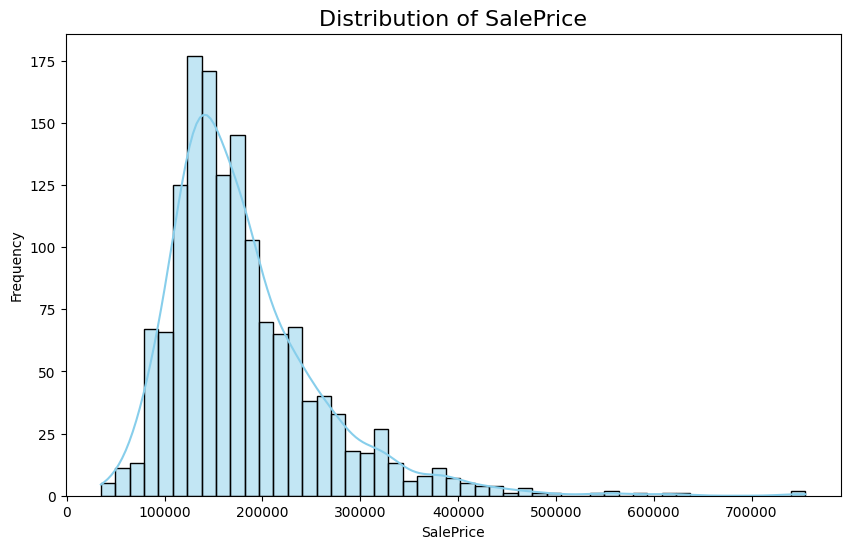

In [5]:
#distribution of SalePrice
plt.figure(figsize = (10, 6))
sns.histplot(train_data['SalePrice'], kde = True, color = 'skyblue')
plt.title('Distribution of SalePrice', fontsize = 16)
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

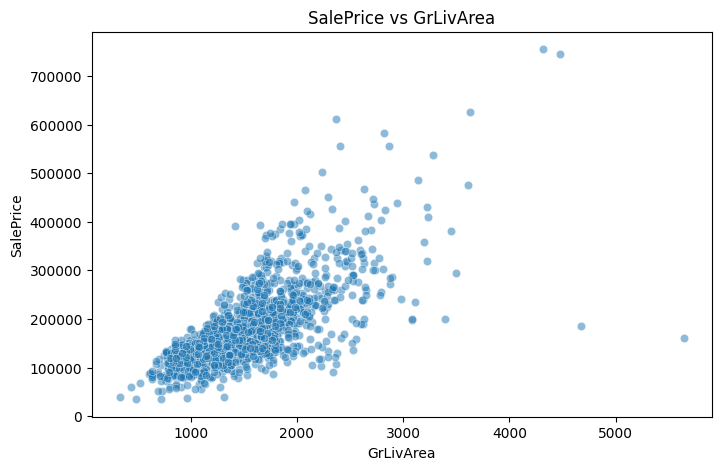

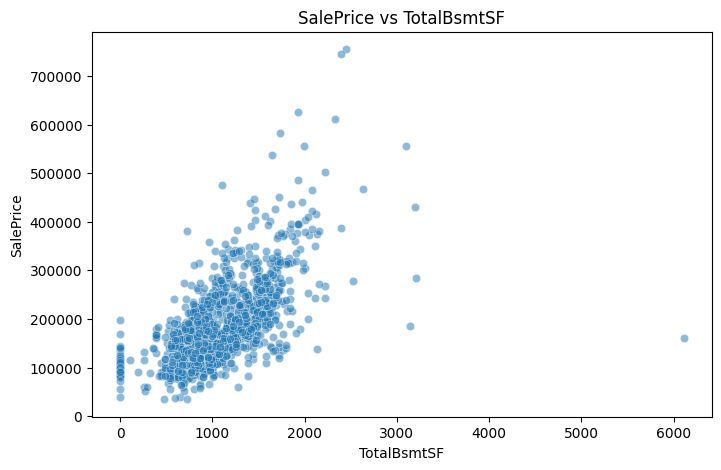

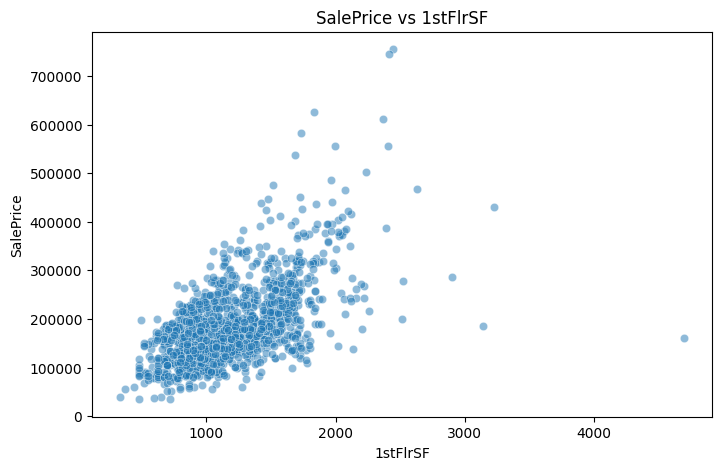

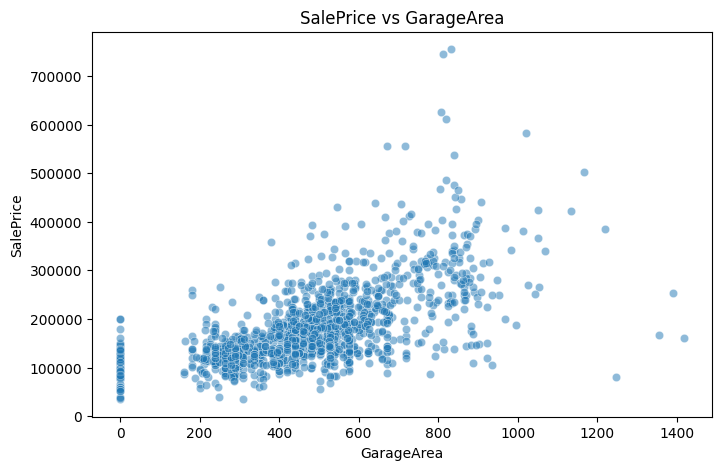

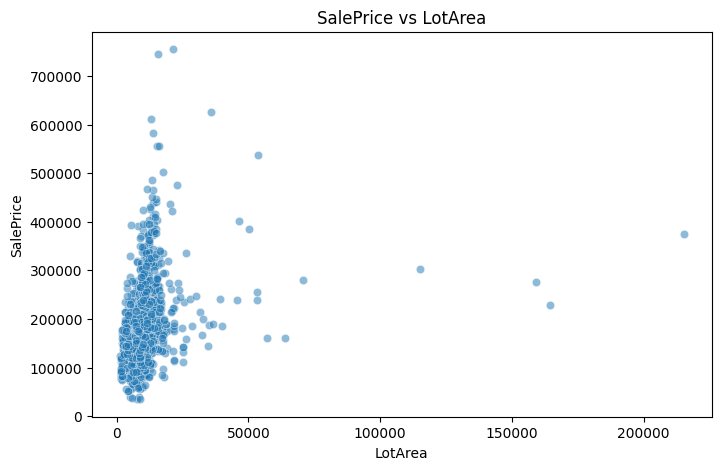

In [6]:
#important numerical features
num_features = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', 'LotArea']

for feature in num_features:
    plt.figure(figsize= (8, 5))
    sns.scatterplot(x = train_data[feature], y = train_data['SalePrice'], alpha = 0.5)
    plt.title(f'SalePrice vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.show()

#the straighter and the tighter = the stronger the relation to saleprice

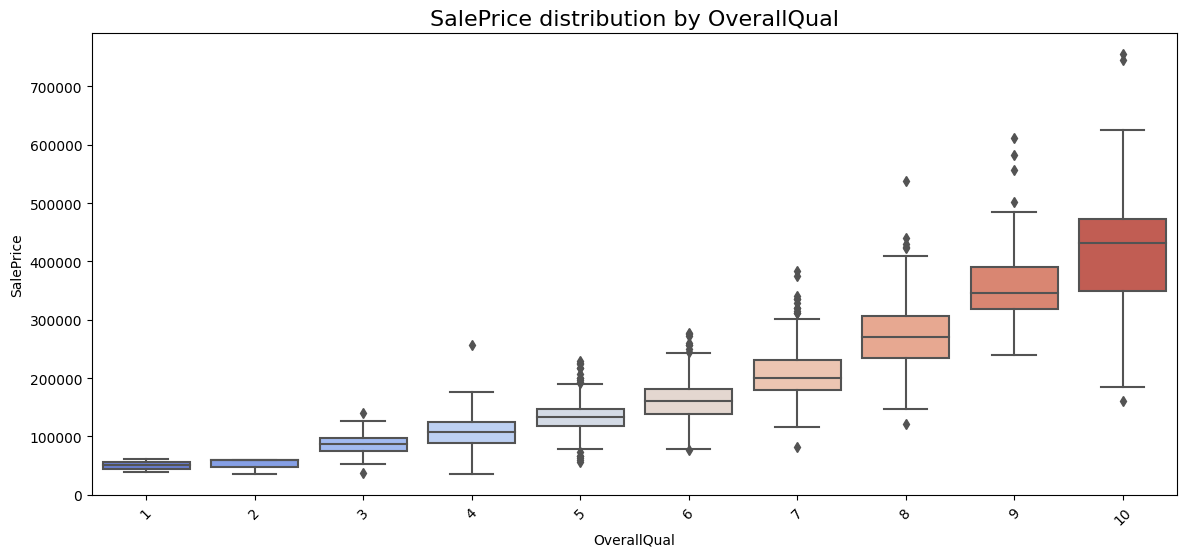

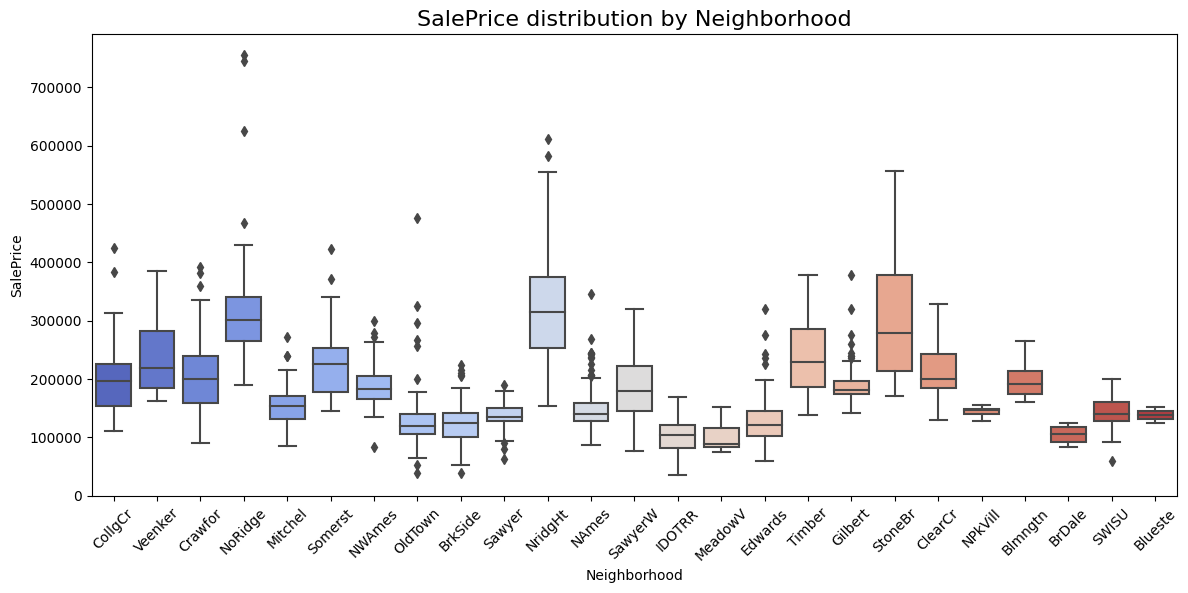

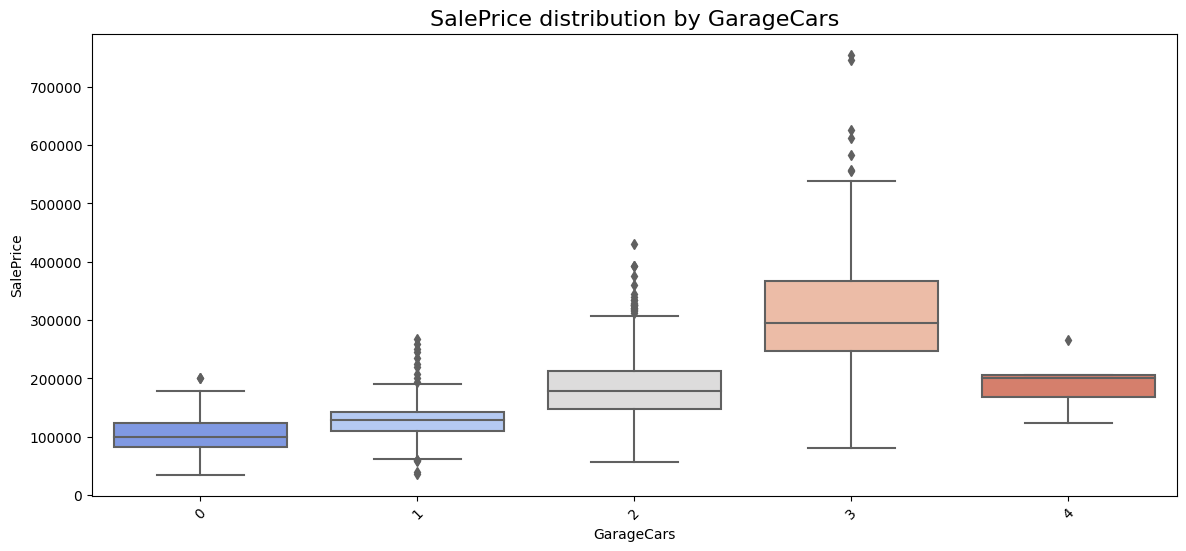

In [7]:
#important categorical features
cat_features = ['OverallQual', 'Neighborhood', 'GarageCars']

for feature in cat_features:
    plt.figure(figsize = (14, 6))
    sns.boxplot(x = feature, y = train_data['SalePrice'], data = train_data, palette = 'coolwarm')
    plt.title(f'SalePrice distribution by {feature}', fontsize = 16)
    plt.xticks(rotation=45)
    plt.show()

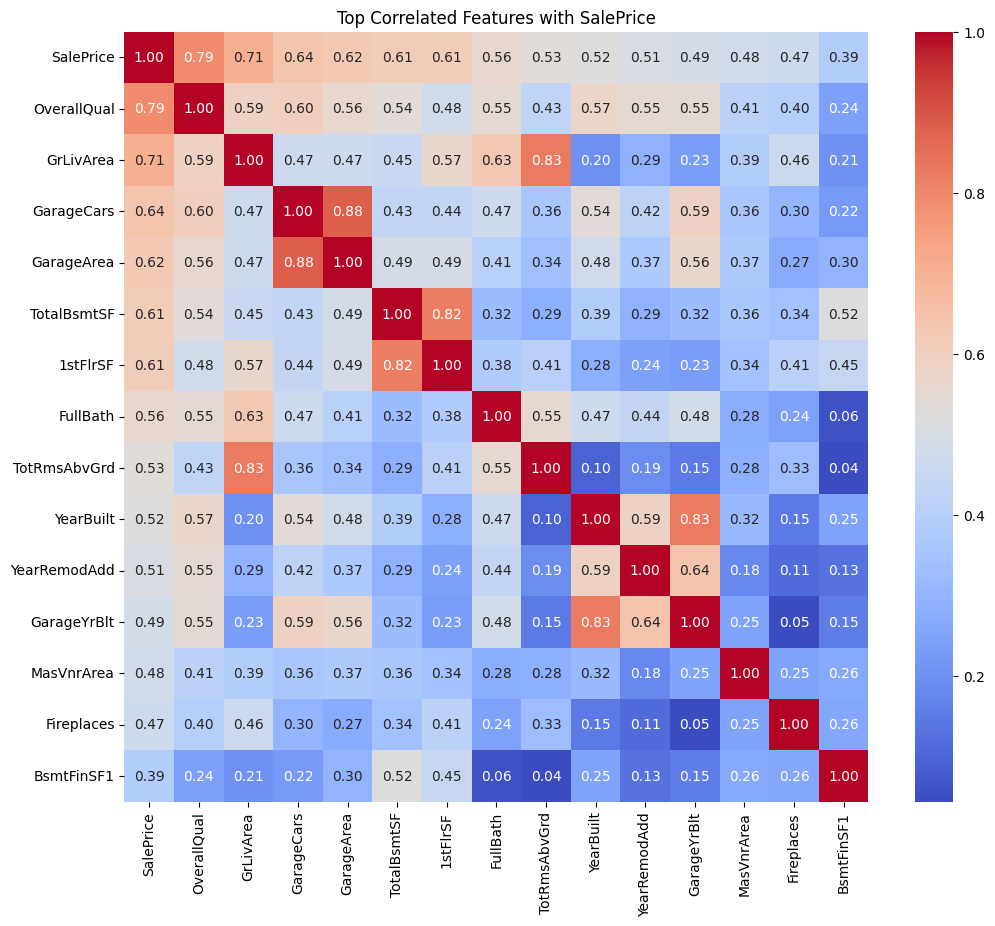

In [8]:
#correlation analysis

#select columns int or float
numeric_features = train_data.select_dtypes(include = ['int64', 'float64']).columns 

#instantiate correlation matrix
corr_matrix = train_data[numeric_features].corr()

#find top 15 correlated numeric features with SalePrice
top_corr_features = corr_matrix['SalePrice'].abs().sort_values(ascending = False).head(15).index

#plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(train_data[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Top Correlated Features with SalePrice')
plt.show()


In [9]:
y = train_data['SalePrice']
train_id = train_data['Id']
test_id = test_data['Id']
#preprocessing func
def preprocess(df):
    df = df.copy() #creating a copy of df
    for col in df.select_dtypes(include = 'object'): #for column in non-numerical columns
        df[col] = df[col].fillna('None') #fill nans with 'None'
        df[col] = LabelEncoder().fit_transform(df[col]) #use labelencoder to transform to numerical
    for col in df.select_dtypes(include = ['int64', 'float64']): #for column in numerical columns
        df[col] = df[col].fillna(df[col].median()) #fill nans with median
    return df

x = train_data.drop(columns = ['Id', 'SalePrice']) #train data feature separation
x = preprocess(x) #train data preprocessing

x_test = test_data.drop(columns = ['Id']) #tests data feature separation
x_test = preprocess(x_test)

#K-Fold Cross Validation
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)#split the data into 5 random folds so we can train and validate the model 5 different times
oof = np.zeros(len(x)) #Out-Of-Fold predictions - an empty array to hold the predictions for each validation samples accross the 5 folds
preds = np.zeros(len(x_test)) #where predictions will be stacked

for fold, (train_idx, val_idx) in enumerate(kf.split(x)): #looping over each fold
    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx] #split into train and validation for x
    y_train, y_val = y.loc[train_idx], y.iloc[val_idx] #split into train and validation for y

    model = lgb.LGBMRegressor(n_estimators = 1000, learning_rate = 0.01, random_state = 42)
    model.fit(
        x_train, y_train,
        eval_set = [(x_val, y_val)],
        callbacks = [
            early_stopping(stopping_rounds = 100),
            log_evaluation(period=100)
        ]
    )

    oof[val_idx] = model.predict(x_val)
    preds += model.predict(x_test / kf.n_splits)

rmse = mean_squared_error(y, oof, squared = False) #root mean squared error
print(f'rmse: {rmse}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3126
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 73
[LightGBM] [Info] Start training from score 181441.541952
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.3356e+09
[200]	valid_0's l2: 1.22874e+09
[300]	valid_0's l2: 9.76738e+08
[400]	valid_0's l2: 8.89607e+08
[500]	valid_0's l2: 8.4478e+08
[600]	valid_0's l2: 8.33104e+08
[700]	valid_0's l2: 8.26842e+08
[800]	valid_0's l2: 8.24209e+08
[900]	valid_0's l2: 8.22418e+08
[1000]	valid_0's l2: 8.21477e+08
Did not meet early stopping. Best iteration is:
[976]	valid_0's l2: 8.20308e+08
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_row_wi

In [10]:
submission = pd.DataFrame({
    'Id' : test_id,
    'SalePrice' : preds
})

submission.to_csv('submission.csv', index = False)
